In [5]:
!pip install opencv-python

In [6]:

# this is for just creating the training dataset and values 
import os, shutil, random 
from pathlib import Path

# paths
raw_data = Path("../dataset_raw") # the path fo the downloaded kaggle dataste 
train_dir = Path("../data/train") # basically our training data
val_dir = Path("../data/val") # baically our validation data 

# make sure folders exist
for p in [train_dir/"real", train_dir/"fake", val_dir/"real", val_dir/"fake"]:
    p.mkdir(parents=True, exist_ok=True)

# function to split
def split_and_copy(src_folder, label, train_dest, val_dest, split_ratio=0.8):
    images = [f for f in Path(src_folder).glob("*") if f.suffix.lower() in [".jpg", ".png", ".jpeg"]]
    random.shuffle(images)
    cut = int(len(images) * split_ratio)
    train_imgs, val_imgs = images[:cut], images[cut:]
    
    for img in train_imgs:
        shutil.copy(img, train_dest/label/img.name)
    for img in val_imgs:
        shutil.copy(img, val_dest/label/img.name)
    
    print(f"{label}: {len(train_imgs)} train, {len(val_imgs)} val")

# split real and fake
split_and_copy(raw_data/"training_real", "real", train_dir, val_dir)
split_and_copy(raw_data/"training_fake", "fake", train_dir, val_dir)

print("✅ Done splitting dataset!")



real: 864 train, 217 val
fake: 768 train, 192 val
✅ Done splitting dataset!


In [7]:
import os #just chking the directory of the notebook
print(os.getcwd())

c:\Users\Jaideep\Desktop\MONASH\ACADEMICS\FIT3144\Research\Model\notebooks


In [1]:
#DOING ALL THE IMPORTS NEEDED AND SETTING THE SEED , BATCH SIZE , ETC

import os, random, numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
from PIL import Image
from tqdm import tqdm
from pathlib import Path

# reproducibility
#A rerun means: you stop your notebook and start training again from scratch (like running all cells from the top).
#With a fixed seed, the randomness (shuffling, jitter, flips, etc.) will happen in the exact same way each time you restart and rerun the notebook.
#Without a seed → every rerun gives a different shuffle order and slightly different augmentations.
random.seed(0); np.random.seed(0); torch.manual_seed(0) # jsut sets the seed, so basically for each epohc we need the same dataset order so to prevent the order to change in every run we set a seed, the order however changes by default in the next epoch 
#so we setting the seed for ranom, numpy, and torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device) #checking if cuda isavailable

DATA_DIR   = Path("../data")   # has train/ and val/
IMG_SIZE   = 224               # resnet expects a uniform resolution , so just converting
BATCH_SIZE = 16                # Basiclaly instead of going 1 image by 1 , the model evaluates images in batches 


Device: cpu


In [7]:
#torchvision.trasnforms helps in preparing images (resize , flips ,etc) so essentially we are preparign the images to load in the CNN 
#torchvision.transforms.compose , basically runs the steps in the bracket , one after the other sequentially
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), #resizing it to 224,224 since thats the requirement for resnet
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1,0.05), # changing the brightness, constrast , stauration and hue to prevent the model from being foolded by color chnages
    # so this helps in prevenitng the model to learn images and their pixels instead we want it to learn general patterns like that its a face regardless of whether its like bright or a shadow.
    #in color jitter each value means the max value to set for colorjitter, so for eg , the brightness can be changed to anything upto 10 percent or 0.1
    #for an image this is randomized only once per epoch 

    transforms.ToTensor(), #converts the image into a pytorch tensor
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),  # IMPT- Still dont entirely get why we are tryna normalize?
    # so we are standardizing the differences so it macthces the dataset of what esnet wass trained on , frist we 
    #subtract the pixel with the values and then we divide by the normal spread to n
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# here val_tfms and train_tfms are variables which store the sequence of  transformations to be applied on the images- later we will call val_tfms on an image 

In [10]:
from torchvision import datasets

DATA_DIR = "../data"  

#loading the dataset from the directory and then assigning 0 and 1 to the classes based on alphabetical order and then appying the transforms
# so as per alphabetical order fake comes before real so fake is 0 and real is 1
train_ds = datasets.ImageFolder(f"{DATA_DIR}/train", transform=train_tfms)
val_ds   = datasets.ImageFolder(f"{DATA_DIR}/val",   transform=val_tfms)

print("Classes:", train_ds.classes)         
print("Class -> index:", train_ds.class_to_idx)
print("Train images:", len(train_ds), " | Val images:", len(val_ds))


Classes: ['fake', 'real']
Class -> index: {'fake': 0, 'real': 1}
Train images: 2040  | Val images: 1212


In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16  # you can adjust, smaller if it crashes on memory

#num workers is the number of cupu processors in the bg used to loas the images, just set to 0 to not cause any issues
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0) # so it returns the image and the label 
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


#data loader is basically a iterator which helps in loading the data in batches and also helps in shuffling the data
#dataloadeer returns the image and the label as a tuple so (image,label)
#label is the ground truth value for the images of the batch
#image is the image tensor of the batch
# rn we are just testing to get one batch
image, label = next(iter(train_loader)) #train_loader is your DataLoader.
#Each time you grab a batch from it, it gives you:
#image = the images (tensor)
#label = the labels (tensor)
print("Batch image tensor shape:", image.shape)   # just confirming if the image is actually a tensor 
print("Batch labels shape:", label.shape)         # e.g., [16]
print("Sample labels:", label.tolist()) # to list just converts tensor into a list


Batch image tensor shape: torch.Size([16, 3, 224, 224])
Batch labels shape: torch.Size([16])
Sample labels: [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]


In [2]:
import torch, torch.nn as nn #torch.nn is  PyTorch’s module for building neural network layers.
from torchvision import models

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Device:", device) #checking if cuda isavailable

# load ResNet18 pretrained on ImageNet
# models.ResNet18_Weights.IMAGENET1K_V1 means to use pretrained weights on imagenet
#so resusing the backbone for feature extraction and just changing the final layer to suit the deepfake detection project 
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


input_features = model.fc.in_features # this is the number of input features to the final layer, its normally 512 for resnet18 but if we change the model it will be different
model.fc = nn.Linear(input_features, 1) # replace the final fc (1000 classes) with a 1-output logit head (binary)
#so model.fc is the final layer of the resnet model 

# model = model.to(device) # just putting the model on the gpu if available, so the images whihc are loaded and model which is running should be run on the same, not like one is cpu and other is gpu, it will show error


In [3]:

#parameters are the weights and biases of the model which are learned during training
#So we freeze all the layers except the final layer so that we dont have to train the entire model from scratch
#just training the final layer for the binary classification of deepfake detection
for p in model.parameters(): #we are going through all the parameters of the model
    p.requires_grad = False #  and setting it to false so that the gradients are not calculated for these layers and hence they are not updated during backpropagation

# Unfreeze only the final layer
for p in model.fc.parameters(): # but for the final layer we want to train it so setting it to true
    p.requires_grad = True

loss_function= nn.BCEWithLogitsLoss() # since its a binary classification problem we are using binary cross entropy loss
#BCEWithLogitsLoss is more numerically stable than using a plain Sigmoid followed by a BCELoss as it combines the operations into one layer.
#BCE Measures loss and how far the predicted value is from the actual value
#how it works is the model outputs a logit and then the logit is passed through a sigmoid function to get a probability between 0 and 1


#the optimizer is used to update the weights of the model based on the gradients calculated during backpropagation
# the learniong rate is the step size of the optimizer, how much to change the weights of the model based on the gradients
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4) # we are only passing the parameters of the final layer to the optimizer since we are only training the final layer
#So how SGD works is 
#How adam is different from SGD is that it maintains a learning rate for each parameter (weight) and adjusts it based on the first and second moments of the gradients. 
#so essentialyh adam remembers the past gradients and uses them to adjust the learning rate for each parameter individually.


In [14]:
def train_one_epoch(model, dataloader, optimizer, loss_function):
     #model is the resnet model
     #dataloader is the batch of images and labels
     #optimizer is the adam optimizer
     #loss_function is the BCEWithLogitsLoss


     #----HOW IT WORKS INTUITION--
    #- Forward pass (make a guess)

    #-The model sees a batch of images (images) and produces one number per image called a logit (logit = model(images)).

    #-Think: “raw confidence” before turning it into a probability.

    #-Compute loss (how wrong was that guess?)

    #-BCEWithLogitsLoss compares each logit with the true label (labels: 0=fake, 1=real).

    #-Conceptually it converts logits → probabilities with a sigmoid, then computes how bad each prediction was.

#-  With the default reduction="mean", it averages the per-image losses into one scalar for the batch: L.

    #-Backprop (turn wrongness into directions to improve)

    #-You call L.backward(). PyTorch uses the previous calculated loss to calculate the gradients through the model.
    #the learing rate is the step size of the optimizer, how much to change the weights of the model based on the gradients
    # the gradeitns formula is dL/dW where L is the loss and W is the weight of the model
    # learning rate and previous calculated loss are used by this formula 
    #new weight = old weight - learning rate * dL/dW OR W = W - lr * GRADIENT
    # if x --through w--->  z -- sigmoid--> y
    # where x is the input image, w is the weight of the model, z is the logit and y is the output probability after passing through sigmoid

    #veven though we calcualte oe loss with BcEWithLogitsLoss it is still linked to every weight cuz of the chain rule
    # so while calculating the gradeitn dl/dw, we  check the contribution of each weight to the loss by checking how much the loss would change if we changed that weight a tiny bit
    # Even though there’s one loss value, each weight contributed differently to producing that loss.
    # By chain rule of calculus, the gradient is passed backward through all the layers, so each weight gets its own gradient value.

    #-“If I nudge each weight a tiny bit, will the loss go up or down, and by how much?”


    model.train()  # set model to training mode , the other mode is model.eval() which is used during validation and testing
    
    # we need these to calculate the loss and accuracy for the epoch, so total loss is the sum of all the losses for each batch
    #we will divide it by the number of batches to get the average loss for the epoch
    #correct predictions is the number of correct predictions made by the model
    # we arent using sklearn metrics since it cant calculate loss dirrectly for gradint descent
    total_loss, correct_predictions, total_images = 0, 0, 0 
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1) #.unsqueeze(1) is just adding an extra dimension to the label tensor so that it matches the requirement of loss calculation 
        # so before for labels it was like label.shape = [16] but now it will be [16,1] so that it matches the output of the model which is also [16,1]
        
        
        # -------forward pass 
        logit= model(images)  
        #forward pass means we arepassing the images through the model to get the output logits
        loss_calculation = loss_function(logit, labels)  # compute loss
        #we are calculating the loss between the output logits and the actual labels using the loss function in our case BCEWithLogitsLoss
        

        # -------backward pass and optimization
        optimizer.zero_grad()  # zero the parameter gradients of the previously calculated gradients in the previous batch 
        #otherwise the gradients will be accumulated o added up  and will affect the current batch

        loss_calculation.backward()  #  this calculates the gradients of the loss with respect to the weights of the model
        optimizer.step()  # adam updates weights
        #so the optimizer will update the weights of the model based on the gradients calculated during backpropagation


        #---------tracking the loss and accuracy for the epoch
        total_loss += loss_calculation.item() * images.size(0)  # accumulate loss, item() just converts the value of the loss tensor into a float
        # images.size(0) is the batch size, so we are multiplying the loss by the batch size to get the total loss for the batch

        predictions = torch.sigmoid(logit) >= 0.5  # get predictions, so if the sigmoid output is greater than 0.5 we consider it as a positive prediction
        correct_predictions+=(predictions.int() == labels.int()).sum().item()  # we are converting the predictions and labels to int tensors and then comparing them to get the number of correct predictions
        total_images += labels.size(0)  # accumulate total images, so we can calculate accuracy
        

    avg_loss= total_loss / total_images  # average loss for the epoch
    accuracy = correct_predictions / total_images  # accuracy for the epoch
    return avg_loss, accuracy

    
    

In [15]:
#now havae to do the validation function, so using eval mode of the model
# its gonna be similar to the train one epoch function but without the backpropagation and optimization steps
#this is because during validation we just want to see how well the model is performing on unseen data and we dont want to update the weights of the model


def validate_one_epoch(model, dataloader, loss_function):
    model.eval()

    total_loss, correct_predictions, total_images = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            logit = model(images)
            loss_calculation = loss_function(logit, labels)

            total_loss += loss_calculation.item() * images.size(0)
            predictions = torch.sigmoid(logit) >= 0.5
            correct_predictions += (predictions.int() == labels.int()).sum().item() # predictions.int and labels.int() just converts the tensor to int tensor so that we can compare then so if 0,0 matches or 1,1 matches then it willl result true
            #and .sum() will add up all the true values to give the total number of correct predictions (so correct includes all the prediction whihch match the ground truth label)
            # for example if the prediction is 0.7 and the label is 1 then we consider it as a correct prediction since both are rounded to 1, so the tensor was before like [0.7] and [1] but after converting to int tensor it will be [1] and [1]
            # so .int rounds of to the nearest integer
            #then we do .sum() which basically adds up all the correct predictions in the batch and then .item() just converts the tensor to a float value
            # if 

            total_images += labels.size(0)

    avg_loss = total_loss / total_images
    accuracy = correct_predictions / total_images
    return avg_loss, accuracy


In [16]:
#now we run the training and validation for a number of epochs and track the loss and accuracy for each epoch

EPOCHS = 5  # sttarting with a ranodm number of epochs, you can increase it later
best_val_loss = float('inf')
best_state = None

for epoch in range(1, EPOCHS + 1): # doing it for 1 to 5 epochs
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_function) # training for one epoch
    val_loss, val_acc = validate_one_epoch(model, val_loader, loss_function) # validating for one epoch

    print(f"Epoch {epoch}/{EPOCHS} | " #here we are printing the loss and accuracy for each epoch, this line just prints the epoch number and total epochs
          f"Train Loss: {train_loss:.4f}  Acc: {train_acc*100:.2f}% | " # here we are printing the training loss and accuracy for each epoch, .4f means 4 decimal places and .2f means 2 decimal places
          f"Val Loss: {val_loss:.4f}  Acc: {val_acc*100:.2f}%") # here we are printing the validation loss and accuracy for each epoch

    # save best-by-validation-loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()} # modekl.state_dict() returns a dictionary containing a whole state (all the model paramaets-weights and biases) of the module
        # a weight tells the model how important a particular feature is for making predictions and a bias allows the model to make adjustments to its predictions based on the input data
        # so the formula is y = wx + b where w is the weight and b is the bias
        
        #.items() returns an object that displays a list of a dictionary's key-value tuple pairs, so it allows us to iterate
        # k and v are the key and value of the dictionary respectively which are the name of the parameter and the tensor value of the parameter respectively
        # v.cpu().clone() is used to clone the tensor and move it to the cpu, so that we can save it later


# (optional) load the best weights back into the model
#th
if best_state is not None:
    model.load_state_dict(best_state) # here we are loading the best weights back into the model
    # this is cuz the model doesnt necessarily have the best weights at the end of the next round  it might have overfitted on the training data
    #overfitting is when the model performs well on the training data but poorly on the validation data
    # that tells us that the model has learned the training data too well and has memorized it instead of learning the general patterns
    # because val data is unseen data so if the model performs well on it then it means that the model has learned the general patterns and not just memorized the training data

    
    # model.to(device) #



Epoch 1/5 | Train Loss: 0.6983  Acc: 53.82% | Val Loss: 0.7029  Acc: 53.55%
Epoch 2/5 | Train Loss: 0.6901  Acc: 55.39% | Val Loss: 0.6937  Acc: 55.69%
Epoch 3/5 | Train Loss: 0.6838  Acc: 56.13% | Val Loss: 0.6863  Acc: 56.68%
Epoch 4/5 | Train Loss: 0.6762  Acc: 58.33% | Val Loss: 0.6819  Acc: 58.09%
Epoch 5/5 | Train Loss: 0.6722  Acc: 59.02% | Val Loss: 0.6760  Acc: 58.66%


In [4]:
#-----integrating heatmap generation using gradcam
#a convolutional filter is a small matrix that is used to detect specific features in an image, such as edges, textures, or patterns.
#its like a pattern detector 
# if it finds the pattern it outputs a high value, otherwise it outputs a low value
#if we collect all these numbers into a 2d array we get a feature map

#mNow gradeints tell us if the feature map is important for the final prediction or not
# gradientts i sbasically dl/dw , so if it is high then it means that changing the weight will change the loss a lot and hence it is important for the final prediction
#but in gradcame the gradient is how much the logit will change if we change the weight for that feature map in the last convolutional layer , so d(logit)/d(Weight)
#if it is 0 it means that changing the weight for that  will not change the logit much and hence it is not important for the final prediction of the logit

#during backpropogration the gradients flow back to each feature map via the chain rule
# f the gradient is large for that feature map, it means: “This map strongly influenced the final decision (loss depends on it).”

#so GRADCAM needs 2 things
#1. the feature maps from the last convolutional layer, last conv layer is used because it has the most abstract features
#2. the gradients of the output with respect to those feature maps, so that we can see which feature maps are important for the final prediction


import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1) target layer (use the last BasicBlock so its output stays in graph)
last_layer = model.layer4[-1]

# 2) store the featuremaps and gradients here (module-level so hooks can write)
feature_maps = {}
gradients = {}

# keep track of hook handles so we can remove/replace safely when re-running the cell
if not hasattr(model, "_gradcam_hook_handles"):
    model._gradcam_hook_handles = []
# remove old hooks if this cell is re-run
for h in model._gradcam_hook_handles:
    try:
        h.remove()
    except Exception:
        pass
model._gradcam_hook_handles = []

def save_feature_map(module, input, output):
    print("Feature map hook called")
    # output is the feature map from this block: shape [B, C, Hc, Wc]
    feature_maps['value'] = output  # DO NOT detach; we want its grad populated

def save_gradient(module, grad_input, grad_output):
    print("Gradient hook called")
    # grad_output[0] is the gradient wrt the block's output: shape [B, C, Hc, Wc]
    gradients['value'] = grad_output[0]

# Register hooks (use full backward hook for reliability on non-leaf modules)
handle_fwd = last_layer.register_forward_hook(save_feature_map)
handle_bwd = last_layer.register_full_backward_hook(save_gradient)
model._gradcam_hook_handles.extend([handle_fwd, handle_bwd])


In [10]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image


def gradcam_on_image(img_path, explain_class="fake"):
    # clear caches so we don't read stale values if a previous run failed before backward
    feature_maps.clear(); gradients.clear()

    model.eval()  # set model to eval mode
    image = Image.open(img_path).convert("RGB")  # open the image and convert to RGB
    
    normalized_image = val_tfms(image).unsqueeze(0).to(device)
    # Ensure the block output keeps grad in the graph. Input doesn't need requires_grad for Grad-CAM,
    # but enabling it is harmless; the critical part is not detaching feature maps in the hook.
    normalized_image.requires_grad_(True)

    # Forward
    logit = model(normalized_image)
    probability_real = torch.sigmoid(logit).item()

    # Pick target score: maximize real or fake
    score = logit if explain_class == "real" else -logit

    # Backward to populate gradients at last block output
    model.zero_grad(set_to_none=True)
    score_scalar = score.squeeze()
    score_scalar.backward(retain_graph=False)

    # Defensive checks to surface clear errors instead of KeyError later
    if 'value' not in gradients:
        print("gradients missing; keys:", list(gradients.keys()))
        raise RuntimeError("Backward hook on last layer did not fire. Ensure hook cell ran AFTER model was created and BEFORE this call.")
    if 'value' not in feature_maps:
        print("feature_maps missing; keys:", list(feature_maps.keys()))
        raise RuntimeError("Forward hook on last layer did not fire. Ensure hook cell ran BEFORE the forward call.")

    grads_from_last_conv = gradients['value']  # [B, C, H, W]
    average_grad = torch.mean(grads_from_last_conv, dim=[2, 3])  # [B, C]

    fmap = feature_maps['value'][0]  # [C, H, W]

    # Weight channels by average gradient
    for i in range(fmap.shape[0]):
        fmap[i, :, :] = fmap[i, :, :] * average_grad[0, i]

    heatmap = torch.sum(fmap, dim=0)
    heatmap = F.relu(heatmap)
    heatmap = heatmap / (torch.max(heatmap) + 1e-8)

    return heatmap, image


img_path = r"C:\Users\Jaideep\Desktop\MONASH\ACADEMICS\FIT3144\Research\Model\data\train\fake\easy_2_1111.jpg"

heatmap, image = gradcam_on_image(img_path, explain_class="fake")


Feature map hook called
Gradient hook called


In [ ]:
# grads_from_last_conv = gradients['value']  # gradients from the last conv layer: shape [B, C, Hc, Wc] which is [batch size, channels, height, width]
# # batch size is 1 since we are passing a single image
# # channels is the number of feature maps in the last conv layer
# # height and width are the spatial dimensions of the feature maps
# average_grad = torch.mean(grads_from_last_conv, dim=[ 2, 3])  
# # we are averaging the gradients across the spatial dimensions (height and width) to get a single value for each channel 
# # we dont average across batch size since it is 1 and we dont average across channels since we want a value for each channel


# feature_map_from_last_conv = feature_maps['value'] [0] ## feature maps from the last conv layer: shape [B, C, Hc, Wc] but we dont need the batch size cuz its just 1  so we take the value whihc is contained 
# # in the 0th index and hence the shape becomes [C, Hc, Wc]


# for i in range(feature_map_from_last_conv.shape[0]):  # iterate thrugh  each channel in the feature map
#     feature_map_from_last_conv[i, :, :] *= average_grad[i]  # here we are multiplying each channels pixel values (all the values like height width everything- each and every pixel) in the feature map with the corresponding average gradient
#     # this is because the average gradient tells us how important that channel is for the final prediction
#     # so if the average gradient is high for that channel then it means that the feature map is important for the final prediction and hence we multiply it with a high value
#     # similarly if the average gradient is low for that channel then it means that the feature map is not important for the final prediction and hence we multiply it with a low value


# heatmap = torch.sum(feature_map_from_last_conv, dim=0)  
# #Each channel does cover the same spatial area of the image, just detects different features.
# # so we are summing across all the channels to get a single 2d array which is the heatmap
# # so if the size of each channel is 7x7 , then each channel covers the same region of size 7x7, but just detects different features 
# # so wht we do is we sum across all the channels , each pixel value , which gives us the importance of that specific pixel value after considering all the channels/patterns (cuz each channel effectively represents the patterns detected by the channel or filter )
# # so if a pixel is important in multiple channels then it will have a high value in the heatmap and hence will be emphasised in the heatmap and likewise low value will be deemphasised

# heatmap = F.relu(heatmap)  # apply ReLU to the heatmap to remove negative values, since we are only interested in the positive values which indicate the important regions
# heatmap /= torch.max(heatmap)  # normalize the heatmap to [0, 1] range by dividing by the maximum value in the heatmap
# # this is because we want to visualize the heatmap so each pixel gives a relative importance of that pixel in the image










KeyError: 'value'

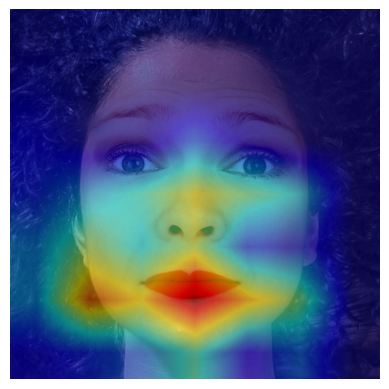

In [11]:
#overlaying heatmap on the original image 

import cv2
import numpy as np

# Ensure heatmap is a CPU float array first
heatmap_np = heatmap.detach().cpu().numpy()

# Resize heatmap to original image size
heatmap_np = cv2.resize(heatmap_np, (image.width, image.height))

# Convert to color map (uint8 0-255 -> JET)
heatmap_color = np.uint8(255 * heatmap_np)
heatmap_color = cv2.applyColorMap(heatmap_color, cv2.COLORMAP_JET)

# Prepare original image as BGR (OpenCV default)
img_rgb = np.array(image)  # PIL to RGB ndarray
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# Blend heatmap with original image using addWeighted for better control
alpha = 0.5  # heatmap weight
beta = 0.5   # image weight
superimposed_bgr = cv2.addWeighted(img_bgr, beta, heatmap_color, alpha, 0)

# Save output in BGR
cv2.imwrite("gradcam_output.jpg", superimposed_bgr)

# Show in notebook (convert back to RGB)
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(superimposed_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [46]:
img_path = r"C:\Users\Jaideep\Desktop\MONASH\ACADEMICS\FIT3144\Research\Model\data\train\fake\easy_2_1111.jpg"  # <-- change this to your image path
gradcam_on_image(img_path, explain_class="fake")  # or "real" if you want to explain the real class